# I. Introduction

   Before the 1870s, North American school systems were largely male-dominated (Parker, 2015). With hopes of shedding light on outdated gender 
biases in the education system, we will look at high school test scores and the corresponding genders of the students that wrote the tests. Specifically, we want to examine if there still remains a level of stratification in terms of how one gender performs in comparison to another. If a signficant enough correlational relationship in performance between genders existed, we would be able to use a student's test score to predict their gender. Thus, the question we will be investigating is: **Is there a correlational relationship between gender and test performance that will allow us to predict a student’s gender based on their test scores and if so, how accurately?**

  We will be using the "Students Performance in Exams" dataset found on Kaggle (Seshapanpu, 2018) to answer this question. This dataset consists of test scores from high schools in America and includes many categorical variables, such as a student's race and their parent's education. In relevance to the question, and in order to create a predictive KNN classification model, this analysis will only be focusing on the `gender`, `math score`, `reading score` and `writing score` columns in the dataset. 

# II. Methods and Results

## Loading the Dataset

We first install the `gsheet` package in order to read in the dataset from a Google Sheets file. We also require the `plotly` package to visualize our results later on. 

We then load the `tidyverse`, `tidymodels`, `repr`, `gsheet`, `gridExtra`, `broom`, `yardstick` and `plotly` libraries to carry out our analysis. 


In [1]:
install.packages('gsheet')
install.packages("plotly")

library(tidyverse)
library(tidymodels)
library(repr)
library(gsheet)
require(gridExtra)
library(broom)
library(yardstick)
library(plotly)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ──────

Since Kaggle requires an account to access and download its datasets, we downloaded the dataset, uploaded it to Google Sheets and used the `gsheet2text` function in the `gsheets` package to format the linked file to have its values separated by commas. We then use `read_csv` to read the file. 

*Table 1.0* shows a preview of the original dataset.

In [2]:
kaggle <- "https://docs.google.com/spreadsheets/d/17G-ujDXnOWzrayNUAV3lmsjhrwd3GPwIRC8_zQA1L8U/edit#gid=0"

doc <- gsheet2text(kaggle, format='csv')

perf <- read_csv(file = doc)

head(perf)

No encoding supplied: defaulting to UTF-8.



gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
female,group B,bachelor's degree,standard,none,72,72,74
female,group C,some college,standard,completed,69,90,88
female,group B,master's degree,standard,none,90,95,93
male,group A,associate's degree,free/reduced,none,47,57,44
male,group C,some college,standard,none,76,78,75
female,group B,associate's degree,standard,none,71,83,78


  **Table 1.0: First Six Rows Of The Dataset**

## Data Wrangling

Before working with this data, we can see from *Table 1.0* that some column names contain spaces and the `race/ethnicity` column contains a '/'. In order for R to read the column names correctly, we need to rename them using the `rename` function. Moreover, other than `gender` and the three numerical test-score columns, the other columns can be excluded since they won't be used. Lastly, since the `gender` column is our categorical statistical variable, we convert it into a factor. 


In [3]:
perf_gen <- perf %>%
               rename("parent_education"= "parental level of education", 
               "race_ethnicity" = "race/ethnicity", 
               "math_score" = "math score", 
               "reading_score" = "reading score", 
               "writing_score" = "writing score",
              "test_prep_course" = "test preparation course") %>%
               select(gender, math_score, reading_score, writing_score)

perf_gen  <- perf_gen %>%
             mutate(gender = as_factor(gender))    


head(perf_gen)


gender,math_score,reading_score,writing_score
<fct>,<dbl>,<dbl>,<dbl>
female,72,72,74
female,69,90,88
female,90,95,93
male,47,57,44
male,76,78,75
female,71,83,78


**Table 1.1: Preview of Wrangled Dataset**

## Summarizing The Data

From *Table 1.1*, we can see that our dataset is now tidy. However, before we can conduct an exploratory analysis, me must first split our dataset into training and testing sets. This prevents the testing set from influencing our model in any way. We arbitrarily decided to use 3/4 of the data for training and 1/4 for testing as this would give us plenty of data to train our classifier.

In [4]:
set.seed(1)
perf_split <- initial_split(perf_gen, prop = 0.75, strata = gender)
perf_train <- training(perf_split)
perf_test <- testing(perf_split)

To check the categories of gender and the number of observations per category in the entire dataset, we used the `group_by` and `summarize` functions. 

In [5]:
num_obs <- nrow(perf_train) ## number of observations in whole dataset

perf_train %>%
  group_by(gender) %>%
  summarize("Number of People"= n(), Percent = n()/ num_obs *100) 
  

`summarise()` ungrouping output (override with `.groups` argument)



gender,Number of People,Percent
<fct>,<int>,<dbl>
female,389,51.7976
male,362,48.2024


**Table 1.2: Summarized Data of Gender Categories**

From *Table 1.2*, it is evident that the categories under `gender` include only males and females and that the training data is fairly evenly split (with 51.8% being female and 48.2% being male). This means that over-representation by one gender will not be an issue.

We then investigated whether or not there was stratification regarding how well one gender scored over another. 

In [6]:
average_test_scores <- perf_train %>%
                       group_by(gender) %>%
                       summarize(avg_math = mean(math_score),
                                 avg_reading = mean(reading_score),
                                 avg_writing = mean(writing_score))
average_test_scores

`summarise()` ungrouping output (override with `.groups` argument)



gender,avg_math,avg_reading,avg_writing
<fct>,<dbl>,<dbl>,<dbl>
female,63.74293,72.86889,72.82776
male,68.20994,65.02210,62.90608


**Table 1.3: Gender Comparison In Test Scores**

## Plotting the Data

From *Table 1.3*, all test scores appear to be suitable predictors because there is a clear difference between all mean scores and genders. Since these values are averages, we need to visualize all the points on the training data as scatter plots to see which two predictors would result in the most distinct clusters of points. We will do this using a colour-blind friendly palette (Chang, 2013).


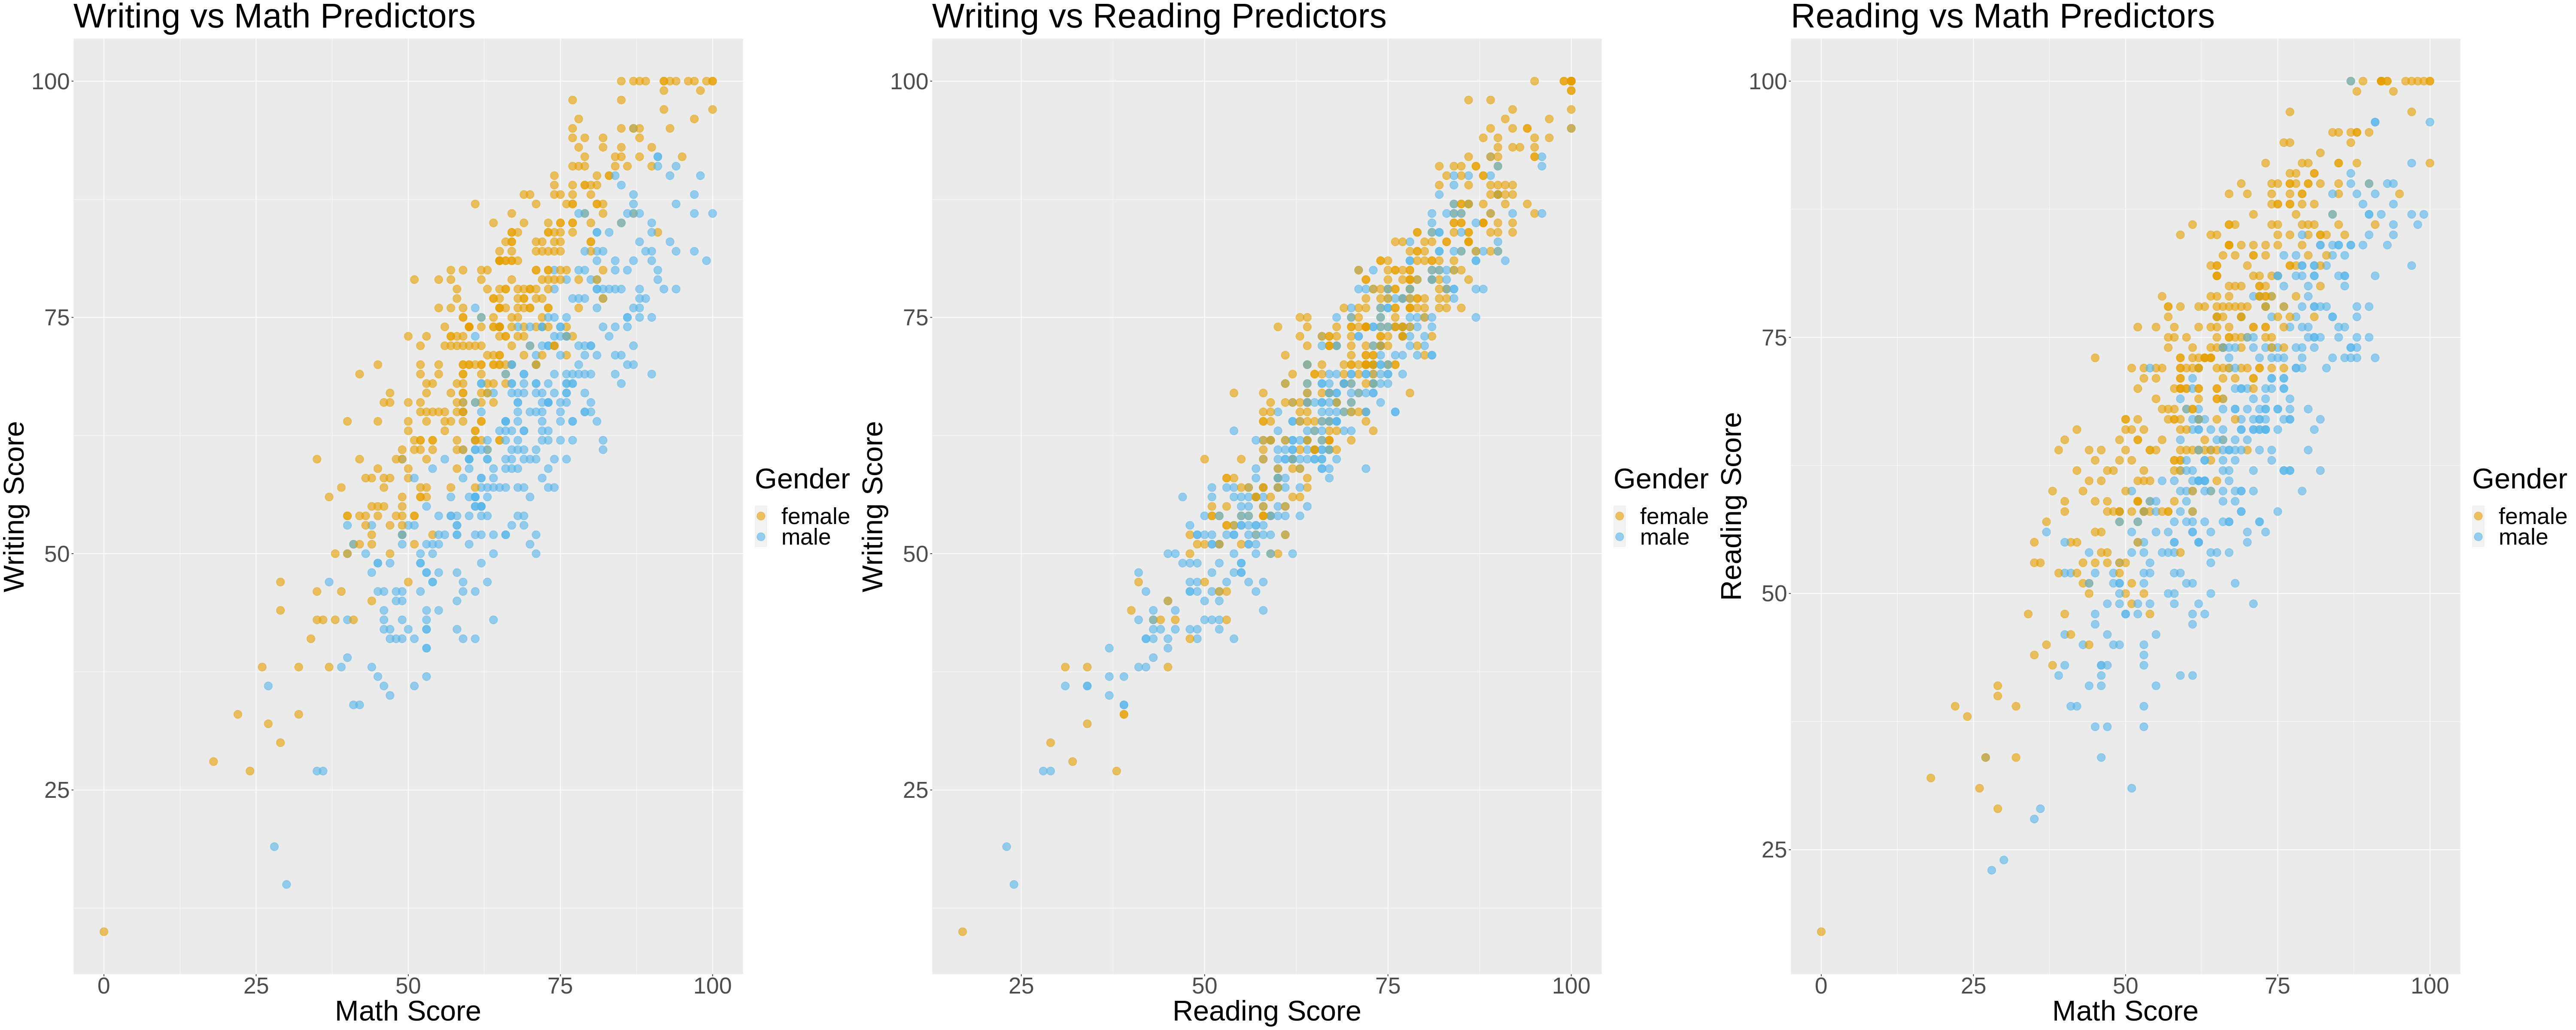

In [7]:
options(repr.plot.width = 50, repr.plot.height = 20)


cbPalette <- c( "#E69F00", "#56B4E9","#999999", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7") 
## using a colour-blind friendly palette


math_writing <- perf_train %>%
              ggplot(aes(x= math_score, y = writing_score, colour = gender)) +
              geom_point(alpha = 0.6, size = 5) + 
              labs(x = "Math Score", y = "Writing Score", colour = "Gender") +
              theme(text = element_text(size = 40)) +
              scale_color_manual(values = cbPalette) +
              ggtitle("Writing vs Math Predictors")

reading_writing <- perf_train %>%
              ggplot(aes(x= reading_score, y = writing_score, colour = gender)) +
              geom_point(alpha = 0.6, size = 5) + 
              labs(x = "Reading Score", y = "Writing Score", colour = "Gender") +
              theme(text = element_text(size = 40)) +
              scale_color_manual(values = cbPalette) +
              ggtitle("Writing vs Reading Predictors")

reading_math <- perf_train %>%
              ggplot(aes(x= math_score, y = reading_score, colour = gender)) +
              geom_point(alpha = 0.6, size = 5) + 
              labs(x = "Math Score", y = "Reading Score", colour = "Gender") +
              theme(text = element_text(size = 40)) +
              scale_color_manual(values = cbPalette) +
              ggtitle("Reading vs Math Predictors")

grid.arrange(math_writing, reading_writing, reading_math, ncol=3)

**Figure 1.0: Visualization of Potential Predictors**

 In reference to the leftmost and rightmost plots, as math scores increases, more females score higher on writing and reading tests, respectively, than males. Both graphs reveal that a correlation between gender and test scores does seem to exist.

For instance, employing `writing_score` and `math_score` (in comparison to `writing_score` and `reading_score`) as our predictors result in a much clearer split between the two genders (*Figure 1.0*). However, we also see a very similar split in the graph that displays the relationship between `reading_score` and `math_score`. 

Therefore, we will first carry out an analysis with three sets of predictors. The predictors used in our first set will be `math_score` and `writing_score` and, in our second set, will be `math_score` and `reading_score`. Our last set will consist of 3 predictors: `math_score`, `writing_score` and `reading_score`. The set of predictors that yields the highest cross-validation accuracy will be the only set we use to build our final model and predict on our test data. Judging by the graphs and summarized tables we had, we also don't need to worry about overplotting or NA values. 


## Building the Model

In order to build our model, we must first choose the $K$ value that we want to use. This will be done by calculating the accuracy of different values of $K$ via cross-validation and choosing the one that yields the most accurate model. Since we have 751 datapoints in our training set, we use 5-fold cross-validation in order to minimize the computational cost. We also set the seed to 16 so that the cross-validation is reproducible. 

In [8]:
set.seed(16)
stuperf_vfold = vfold_cv(perf_train,v = 5,strata = gender)

Next we create a model specification for KNN classification using the `nearest_neighbor` function. By making `neighbors = tune()`, we let R know that we're going to be using a range of $K$ values.

In [9]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")

Since we will be using three different sets of predictors to choose the best model, we are going to need to create three workflows and perform three sets of cross-validations for each set of predictors. Below, we show the workflows and the recipes we need. Note that even though the scaling of the predictors (from *Figure 1.0*) appears to be the same, we scale and center them anyway as a best practice.

In [10]:
## Recipe and workflow for the First Set of Predictors
math_writing_recipe <-  recipe(gender ~ math_score + writing_score, data = perf_train) %>% 
                   step_scale(all_predictors()) %>% 
                   step_center(all_predictors())

workflow_mw <- workflow() %>% 
            add_recipe(math_writing_recipe) %>%
            add_model(knn_spec)

## Recipe and workflow for the Second Set of Predictors
math_reading_recipe <-  recipe(gender ~ math_score + reading_score, data = perf_train) %>% 
                   step_scale(all_predictors()) %>% 
                   step_center(all_predictors())

workflow_mr <- workflow() %>% 
            add_recipe(math_reading_recipe) %>%
            add_model(knn_spec)


## Recipe and workflow for the Third Set of Predictors
math_reading_writing_recipe <-  recipe(gender ~ math_score + reading_score + writing_score, data = perf_train) %>% 
                   step_scale(all_predictors()) %>% 
                   step_center(all_predictors())

workflow_mrw <- workflow() %>% 
            add_recipe(math_reading_writing_recipe) %>%
            add_model(knn_spec)

Now that we have our workflows and recipes, we can go choose a range of $K$ values to use for cross-validation using the `tune_grid()` function. However, rather than letting R pick which $K$ values it uses we are going to specify the range of neighbors we want to be from 1 to 20. We do this below by setting the `grid =` argument to a table we create (which we name `gridK`) .

In [11]:
gridK = tibble(neighbors = seq(from = 1, to = 20, by = 1))

We can now carry out the cross-validation for each candidate set of predictors and collect their metrics. We use `filter` to specify that we want values for accuracy and we use the `arrange` and `head` functions to view the highest accuracy. These accuracies are shown from *Tables 2.0-2.2*

In [12]:
## Accuracy for math_score and writing_score predictors

tuningacc_mw <- workflow_mw %>% 
                tune_grid(resamples = stuperf_vfold,grid = gridK) %>% 
                collect_metrics() %>%
                filter(.metric == 'accuracy') 

highest_accuracy1 <-  tuningacc_mw %>% 
                     arrange(desc(mean)) %>%
                     head(1)

## Accuracy for math_score and reading_score predictors

tuningacc_mr <- workflow_mr %>% 
                tune_grid(resamples = stuperf_vfold,grid = gridK) %>% 
                collect_metrics() %>%
                filter(.metric == 'accuracy') 

highest_accuracy2 <-  tuningacc_mr %>% 
                     arrange(desc(mean)) %>%
                     head(1)

## Accuracy for math_score, reading_score and writing_score predictors

tuningacc_mrw <- workflow_mrw %>% 
                tune_grid(resamples = stuperf_vfold,grid = gridK) %>% 
                collect_metrics() %>%
                filter(.metric == 'accuracy') 

highest_accuracy3 <-  tuningacc_mrw %>% 
                     arrange(desc(mean)) %>%
                     head(1)


In [13]:
highest_accuracy1

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
11,accuracy,binary,0.8695521,5,0.01341009,Model11


**Table 2.0: Highest Accuracy for Math and Writing Predictors**

In [14]:
highest_accuracy2  

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
5,accuracy,binary,0.8242523,5,0.01956461,Model05


**Table 2.1: Highest Accuracy for Math and Reading Predictors**

In [15]:
highest_accuracy3  

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
19,accuracy,binary,0.8722274,5,0.01062742,Model19


**Table 2.2: Highest Accuracy for Math, Reading, and Writing Predictors**

From the above tables, we can discern that using Math, Reading, and Writing Test Scores as our predictors yielded the highest cross-validation accuracy (87.2%) (*Table 2.2*). Coversely, using Math and Writing Test Scores gave the second highest accuracy (86.9%) (*Table 2.0*) and using Math and Reading Test Scores resulted in the worst accuracy (82.4%) (*Table 2.1*). To determine if the number of neighbors obtained is stable, we also plot the accuracy against neighbors below (*Figure 2.0*). Since we have three sets of predictors to plot, we can create one plot in the following manner: 

We create a new column called `v_type` for each workflow and use this to assign a factor that corresponds to the type of test scores used. Then, using `rbind`, we can collect the rows of all the workflows into one dataframe. Similary, we can do the same thing with the highest accuracies for each workflow (`accuracy_highest`). We can then plot everything as a scatter and line plot with `color = v_type`. We also labelled the highest accuracy estimate for each predictor set using `annotate` and `geom_point`.

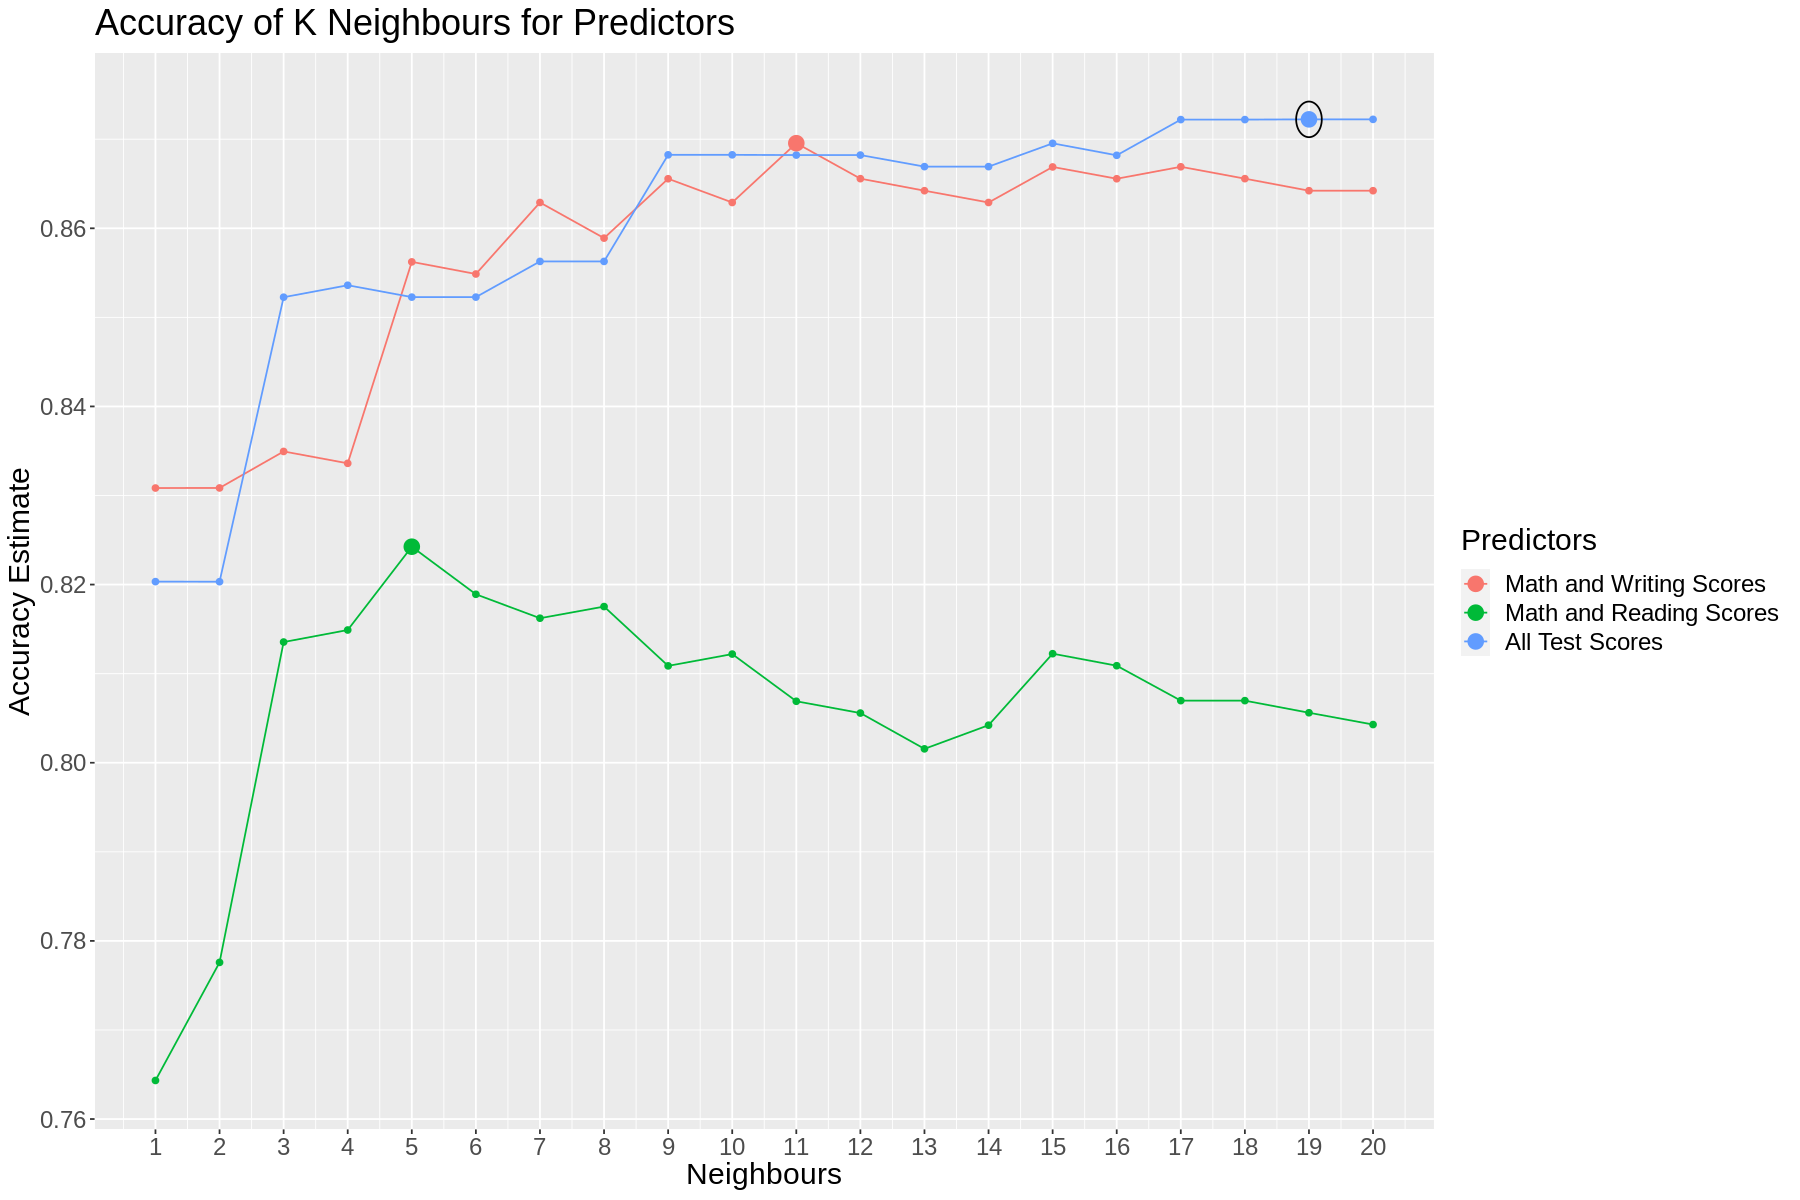

In [27]:
options(repr.plot.width = 15, repr.plot.height = 10)
#Modifying the accuracy tables so that they're "labelled" with the corresponding set of predictors used

tuningacc_mw_clean <- tuningacc_mw %>% 
                       mutate(accuracy = mean,v_type=factor("Math and Writing Scores")) %>% 
                       select(accuracy,neighbors,v_type)

tuningacc_mr_clean <- tuningacc_mr %>% 
                      mutate(accuracy = mean,v_type=factor("Math and Reading Scores")) %>% 
                      select(accuracy,neighbors,v_type)
tuningacc_mrw_clean <- tuningacc_mrw %>% 
                       mutate(accuracy = mean,v_type=factor("All Test Scores")) %>% 
                       select(accuracy,neighbors,v_type)

#combining all the dataframes using rbind

accuracy_all <- tuningacc_mw_clean %>% 
                rbind(tuningacc_mr_clean) %>% 
                rbind(tuningacc_mrw_clean)

#combining highest accuracies for each set of predictors into one dataframe
accuracy_highest <- head(arrange(tuningacc_mw_clean,desc(accuracy)),1) %>% 
                    rbind(head(arrange(tuningacc_mr_clean,desc(accuracy)),1)) %>% 
                    rbind(head(arrange(tuningacc_mrw_clean,desc(accuracy)),1))

#getting the x and y values of the higest accuracy point of all the sets of predictors 
highest_point <- c(head(arrange(accuracy_highest,desc(accuracy)),1)$neighbors[1],
                    head(arrange(accuracy_highest,desc(accuracy)),1)$accuracy[1])

accuracy_vs_k_all <- ggplot(accuracy_all, aes(x=neighbors, y =accuracy,color=v_type)) +
                geom_line() +
                geom_point() +
                labs(x= 'Neighbours', y= 'Accuracy Estimate',color="Predictors") +
                scale_x_continuous(breaks = seq(0, 20, by = 1)) +
                ggtitle("Accuracy of K Neighbours for Predictors") +
                theme(text = element_text(size = 18))+
                geom_point(data=accuracy_highest,aes(x=neighbors, y=accuracy),size=4)+
                annotate("path",
                   x=highest_point[1]+0.2*cos(seq(0,2*pi,length.out=100)),
                   y=highest_point[2]+0.002*sin(seq(0,2*pi,length.out=100))
                )

accuracy_vs_k_all

**Figure 2.0: Accuracy vs K Values for All Sets of Predictors**

From *Figure 2.0*, we see that the 19 neighbors used for the Math, Reading and Writing Score Predictors is on a very stable plateau, with little to no fluctuation of accuracy when the neighbors are 18 or 20. This is contrary to the other two sets of predictors which have their highest-accuracy $K$ value on peaks. As well, the accuracy estimate obtained is the higest when all three scores are used as predictors. Therefore, all three test scores, together, will be used as our predictors for the final predictive model. Although 19 neighbors is a relatively large number of neighbors to use, it should provide more accurate predictions. Moreover, the fact that the points seem to be increasing in accuracy (rather than decreasing) as $K$ increases suggests that a more "accurate" $K$ value is likely larger than the range we used. At the risk of overfitting the data and making our model too computationally expensive, we will not look beyond the range we have set. 

## Carrying Out Predictions Using the Test Data

Using all three test scores as our predictors, we will create our final classifier and determine its prediction accuracy on the test data. To do this, we create a new model specification (`knn_final`) and specify `neighbors = 19`. We then create a new workflow (with `fit` instead of `tune_grid`). Lastly, we make our classifier predict students' gender using the `predict` function. 

We display the accuracy of our predictions in *Table 3.0* and visualize it as a confusion matrix in *Figure 3.0*.

In [18]:
# define best knn workflow
knn_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 19) %>%
       set_engine("kknn") %>%
       set_mode("classification")

workflow_final <- workflow() %>% 
                add_recipe(math_reading_writing_recipe) %>% 
                add_model(knn_final) %>%
                fit(data = perf_train)

predict_final <- workflow_final %>%
                 predict(perf_test) %>%
                 bind_cols(perf_test)

result_final <- predict_final %>% 
                metrics(truth = gender,estimate = .pred_class) %>%
                filter(.metric == 'accuracy')

result_confmat <- predict_final %>% 
                conf_mat(truth = gender, estimate = .pred_class)


In [19]:
result_final

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8674699


**Table 3.0: Classifier Prediction Accuracy**

In [20]:
result_confmat

          Truth
Prediction female male
    female    109   13
    male       20  107

**Figure 3.0: Confusion Matrix of Model Accuracy**

## Visualizing the Results of Our Model

To better visualize the accuracy of our model, we first created a coloured version of our confusion matrix using `geom_tile` (*Figure 4.0*). The correct predictions are in green while the incorrect predictions are in red. This makes it a bit easier to understand than *Figure 3.0* and reveals that the proportion of correctly predicted genders was very similar for both males and females.

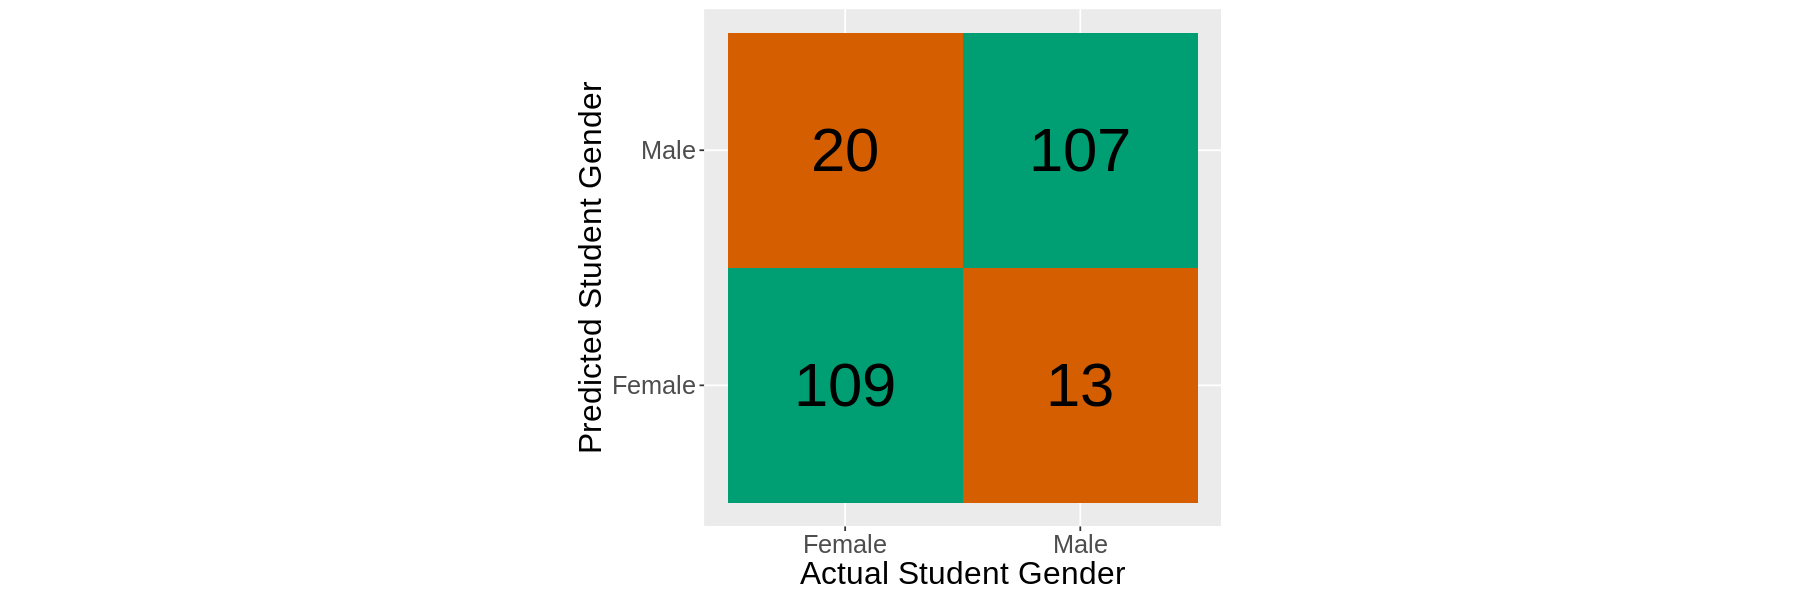

In [21]:
 options(repr.plot.width = 15, repr.plot.height = 5)

conf_pallete <- c( "#D55E00", "#D55E00", "#009E73", "#009E73")
##Christmas Colours because t'is the season

Truth <- factor(c("Male", "Male", "Female", "Female"))
Prediction <- factor(c("Male", "Female", "Male", "Female"))
Y <- factor(c(107, 13, 20, 109))


df <- data.frame(Truth, Prediction, Y)
##Dataframe of our confusion matrix

conf_matrix_plot <- df %>%
                        ggplot(aes(Truth, Prediction, fill = Y)) +
                        geom_tile(show.legend = FALSE) + 
                        coord_equal() + 
                        theme(text = element_text(size = 19)) +
                        scale_fill_manual(values = conf_pallete, name = "Prediction Accuracy") +
                        labs(x = "Actual Student Gender", y = "Predicted Student Gender") +
                        geom_text(aes(label= Y), size = 13)


conf_matrix_plot

**Figure 4.0: Coloured Confusion Matrix of Model Accuracy**

We also chose to visualize our model's predictions using a 3D plot. The drawback of *Figure 4.0* is that it does not tell us where in the data these errors were made. Although it is generally more difficult to read 3D plots, through *Figure 5.0* we are able to garner an idea of where our model made errors (i.e. where the Actual Gender and Predicted Gender differed). 

To create the 3D plot, we used the `plot_ly` function, plotted the predicted scores of all three scores, and colored those points based on whether the actual gender matched the predicted gender or not. Since the plot created was interactive and not accessible as an html file, we downloaded an image of the plot from an isometric viewpoint, uploaded it to Imgur and placed it below using a markdown cell. 

In [22]:

#creating a column called "result" which shows the predicted gender against the actual gender (seperated by "|")
predict_final_clean <- predict_final %>%
                            mutate(result=paste(gender,"|",.pred_class)) %>% 
                            select(math_score,writing_score,reading_score,result)

#a pallete of relatively distinct colours
scatter_pallete <- c( "#ffda75", "#fc0341", "#441df2", "#8fd4ff")


allgraph <- plot_ly(width=1000, height=600, colors = scatter_pallete) %>%
                    add_trace(
                        type = 'scatter3d',
                        mode = 'markers',
                        x= predict_final_clean$math_score, 
                        y= predict_final_clean$writing_score, 
                        z= predict_final_clean$reading_score,
                        color=predict_final_clean$result,
                        marker = list(
                            size=5, 
                            opacity=0.75
                        ),
                        hovertemplate = paste('<i>Math Score</i>: %{x:.2f}<br>',
                                            '<i>Writing Score</i>: %{y:.2f}<br>',
                                            '<i>Reading Score</i>: %{z:.2f}<br>'),
                        showlegend = TRUE
                    ) %>% 
                    layout(
                        title = "Classification Model of Student Test Scores",
                        scene = list(
                            xaxis = list(title = "Math Score"),
                            yaxis = list(title = "Writing Score"),
                            zaxis = list(title = "Reading Score")
                        ),
                        legend = list(title = list(text='<b> Actual Gender | Predicted Gender </b>'))
                    )

#allgraph
#The call to allgraph is commented out to prevent a blank space from being loaded below in html format

![Isometric View](https://i.imgur.com/X0LSvML.png)

**Figure 5.0: 3D Scatterplot of Prediction Model**

# III. Discussion

Ultimately, we found that gender correlated with test scores based on the dataset we used. For all three types of tests (math, writing and reading), the test scores of female students were distinct enough from the test scores of males that they could create a classifier with a prediction accuracy of 86.7%. Moreover, across all three test types, a large amount of females obtained equal or higher scores than males. This is best evidenced by the distribution of points in *Figure 1.0* in which the female test-points lie above or within the male test-points. From *Figure 5.0*, we see that our classifier made most of its errors in the areas where female and male test scores overlapped. More importantly, the plot displays the formation of two distinct groups of points for each gender. This is significant because it involves the test data and yet, continues to show the same patterns seen in *Figure 1.0*. 


From our exploratory analysis, we expected to find, with relatively high accuracy, that either math and reading test scores or math and writing test scores would result in the highest cross-validation accuracy. This is due to the distinct grouping that formed when they were plotted in our exploratory analysis. Based on the lack of grouping observed when we plotted reading scores against writing scores, we did not expect for all three test scores, together, to result in the highest accuracy and  were surprised when, in fact, it did. This finding reveals that, holistically, a significant enough gap in test performance between both genders exists in all three types of tests. 


 With these results, a few key impacts can be identified. First, it seems that gender biases against females performing poorly in academic settings can be put to rest as most performed equally or superiorly to males. Second, considering that our classifier was able to predict the genders of students in our test data with a relatively high accuracy, there seems to be a significant disparity in terms of school performance between genders. Either due to content delivery or content learning, there is a significant enough difference in test performance for our classifier to work. Although limited to the sample our dataset used, our visualizations indicate that males are performing worse than females in general. In order to forge an education system based on equity, it is crucial to pinpoint the cause of this shortfall and minimize the performance gap between genders. However, gender might not be the biggest contributor towards the gap in test scores. We could take a look at other factors  in the form of the following questions:  Does school location influence the difference between the average test scores of males and females? How does this affect the score? Another question we could ask is: How accurately do test scores predict the gender and test preparation of a student?
 
 
Hopefully in the near future this type of data exploration won’t be needed to disprove existing gender biases. Across a number of diverse industries, gender biases still exist in today’s world. The abolishment of such biases are important in our society and we think this analysis yields helpful results in supporting this. 


# IV. References


Chang, W. (2013). Colors (ggplot2). Retrieved December 02, 2020, from http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/

Parker, P. (2015). The Historical Role of Women in Higher Education. Administrative Issues Journal Education Practice and Research, 5(1). doi:10.5929/2015.5.1.1

Seshapanpu, J. (2018, November 09). Students Performance in Exams. Retrieved December 02, 2020, from 
https://www.kaggle.com/spscientist/students-performance-in-exams